# Kaggle Competition - Improving Zillow Zestimate

Submission by Robert Latimer

## Introduction

Zillow’s Zestimate home valuation has shaken up the U.S. real estate industry since first released 11 years ago.

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important. The Zestimate was created to give consumers as much information as possible about homes and the housing market, marking the first time consumers had access to this type of home value information at no cost.

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today), Zillow has since become established as one of the largest, most trusted marketplaces for real estate information in the U.S. and a leading example of impactful machine learning.

Zillow Prize, a competition with a one million dollar grand prize, is challenging the data science community to help push the accuracy of the Zestimate even further. Winning algorithms stand to impact the home values of 110M homes across the U.S.

In this million-dollar competition, participants will develop an algorithm that makes predictions about the future sale prices of homes. The contest is structured into two rounds, the qualifying round which opens May 24, 2017 and the private round for the 100 top qualifying teams that opens on Feb 1st, 2018. In the qualifying round, you’ll be building a model to improve the Zestimate residual error. In the final round, you’ll build a home valuation algorithm from the ground up, using external data sources to help engineer new features that give your model an edge over the competition.

Because real estate transaction data is public information, there will be a three-month sales tracking period after each competition round closes where your predictions will be evaluated against the actual sale prices of the homes. The final leaderboard won’t be revealed until the close of the sales tracking period.

The goal of this model is to improve the Zestimate residual error. More specifically, we are trying to minimize the mean absolute error between the predicted log error and the actual log error. This information is recorded in the transactions training data.

**logerror = log(Zestimate) − log(SalePrice)
 **
 
For each property (unique parcelid), we will predict a log error for each time point. We should be predicting 6 timepoints: **October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712)**. The file should contain a header and have the following format:

`ParcelId,201610,201611,201612,201710,201711,201712
10754147,0.1234,1.2234,-1.3012,1.4012,0.8642,3.1412
10759547,0,0,0,0,0,0
etc.`

## Environment Setup

Load modules for data analysis and visualization.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.stats as stats
import lightgbm as lgb
% matplotlib inline

## Import Data

We have four spreadsheets:
    * properties_2016.csv - all the properties with their home features for 2016.
    * train_2016_v2.csv - the training set with transactions from 1/1/2016 to 12/31/2016
    * sample_submission.csv - a sample submission file in the correct format
    * zillow_data_dictionary.xlsx - explains the data fields

### Training Data

The `Training Data` dataset contains the log error and transaction dates for 90,275 homes sold during 2016.

In [5]:
train_data = pd.read_csv('train_2016_v2.csv', parse_dates =["transactiondate"])
print train_data.shape
train_data.head(10)

(90275, 3)


,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02
5,11509835,-0.2705,2016-01-02
6,12286022,0.0440,2016-01-02
7,17177301,0.1638,2016-01-02
8,14739064,-0.0030,2016-01-02
9,14677559,0.0843,2016-01-03


### Property Data

The `Property Data` dataset contains 58 different features (or details) on almost 3 Million homes! Unlike the `Training Data`, this dataset features information on all homes - not just ones that have been sold. We will see that many of the homes in this dataset are missing information, signaling that this dataset will likely need some pruning!

In [6]:
property_data = pd.read_csv('properties_2016.csv')
print property_data.shape
property_data.head(10)

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN
5,10898347,NaN,NaN,NaN,0.0,0.0,4.0,7.0,NaN,NaN,...,1.0,NaN,176383.0,283315.0,2015.0,106932.0,3661.28,NaN,NaN,NaN
6,10933547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,397945.0,554573.0,2015.0,156628.0,6773.34,NaN,NaN,NaN
7,10940747,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,1.0,NaN,101998.0,688486.0,2015.0,586488.0,7857.84,NaN,NaN,NaN
8,10954547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
9,10976347,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,218440.0,261201.0,2015.0,42761.0,4054.76,NaN,NaN,NaN


## Visualize and Clean Data
`Property Data` contains several cells with the value "NaN", which means "Not a Number". This means that the information for that property is missing. If we look at the first home entry above, we discover that it is missing information for "`airconditioningtypeid`", "`architecturalstyletypeid`", "`basementsqft`", "`buildingclasstypeid`", in addition to too many other categories to list. Because "NaN" is difficult to quantify, we will likely replace it with "0", but we will take it case-by-case as we continue to explore the information.  

Let's take a deeper look at each feature (column) to see the percentage of houses that actually have information (not "NaN") in its respective feature. If 99% of the homes are missing information on, say, "`architecturalstyletypeid`", there will not be a great amount of information gained by keeping that feature in our dataset.

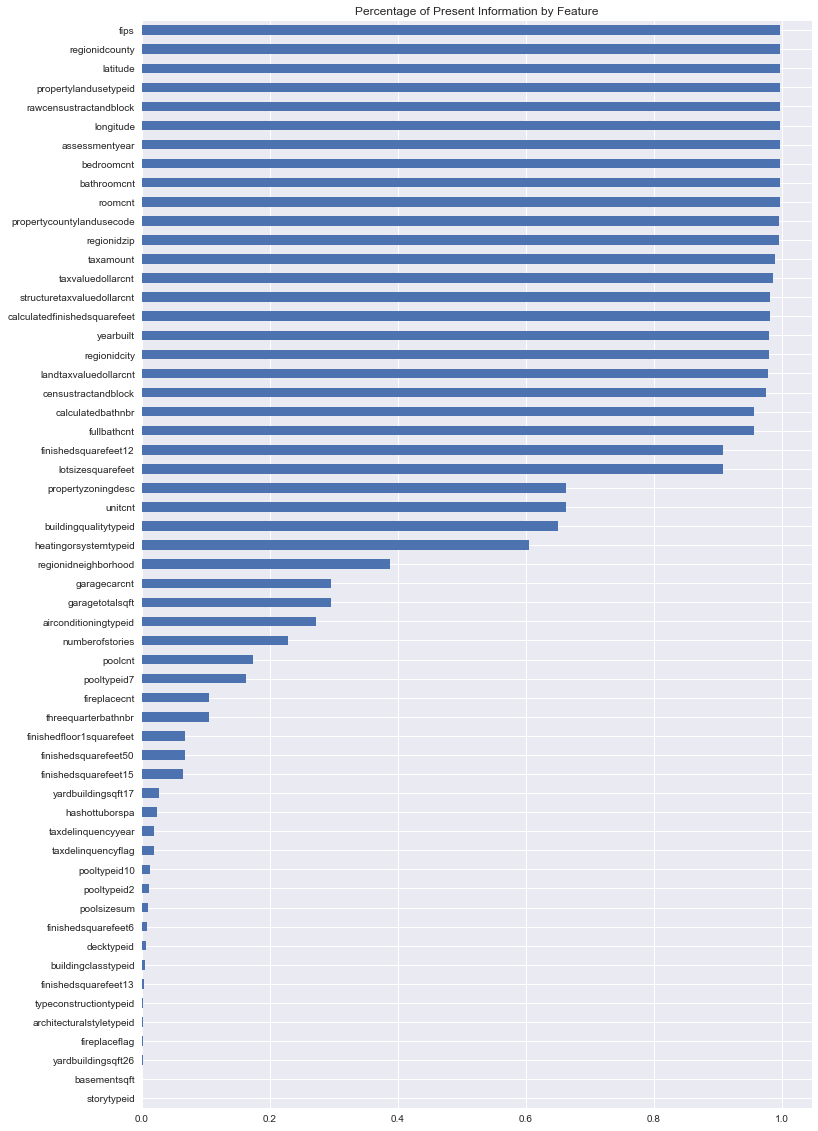

In [7]:
plt.figure(figsize=(12,20))
property_data.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = True).plot(kind = 'barh')
plt.title('Percentage of Present Information by Feature')


In [8]:
property_data.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = False)

fips                            0.996169
regionidcounty                  0.996169
latitude                        0.996169
propertylandusetypeid           0.996169
rawcensustractandblock          0.996169
longitude                       0.996169
assessmentyear                  0.996168
bedroomcnt                      0.996164
bathroomcnt                     0.996160
roomcnt                         0.996156
propertycountylandusecode       0.995887
regionidzip                     0.995317
taxamount                       0.989532
taxvaluedollarcnt               0.985746
structuretaxvaluedollarcnt      0.981582
calculatedfinishedsquarefeet    0.981387
yearbuilt                       0.979925
regionidcity                    0.978948
landtaxvaluedollarcnt           0.977311
censustractandblock             0.974834
calculatedbathnbr               0.956817
fullbathcnt                     0.956817
finishedsquarefeet12            0.907533
lotsizesquarefeet               0.907511
propertyzoningde

Aha, as expected "`architecturalstyletypeid`" is present in less than 1% of the homes listed. In fact, there are several features that are only present in less than 1% of homes. Intuition says that because these features are mostly absent, they are unlikely to help shed a great deal of insight. Another interesting thing of note is that there is not a single feature that is present in 100% of the homes.

Before we decide to drop some of the (mostly-missing) features, let's make sure that a cell that reads "NaN" is really symbolic of a "No". For example, if a home has a pool, "`hashottuborspa`" may have information entered, but if a home doesn't have a pool, "NaN" is entered. Knowing whether or not a home has a pool is valuable information, so let's correct that category and a few others in similar scenarios.

### Pools & Hot tubs

There are actually multiple features related to pools: 
* **"`poolcnt`"** - Number of pools on a lot. "NaN" means "0 pools", so we can update that to reflect "0" instead of "NaN".

* **"`hashottuborspa`"** - Does the home have a hottub or a spa? "NaN" means "0 hottubs or spas", so we can update that to reflect "0" instead of "NaN".

* **"`poolsizesum`"** - Total square footage of pools on property. Similarly, "NaN" means "0 sqare feet of pools", so we can also adjust that to read "0". For homes that do have pools, but are missing this information, we will just fill the "NaN" with the median value of other homes with pools.

* **"`pooltypeid2`" & "`pooltypeid7`" & "`pooltypeid10`"** - Type of pool or hottub present on property. These categories will only contain non-null information if "`poolcnt`" or "`hashottuborspa`" contain non-null information. For the pool-related categories, we can fill the "NaN" value with a "0". And because "`pooltypeid10`" tells us the exact same information as "`hashottuborspa`", we can probably drop that category from our model.

In [15]:
# "0 pools"
property_data.poolcnt.fillna(0,inplace = True)

# "0 hot tubs or spas"
property_data.hashottuborspa.fillna(0,inplace = True)
# Convert "True" to 1
property_data.hashottuborspa.replace(to_replace = True, value = 1,inplace = True)

# Set properties that have a pool but no info on poolsize equal to the median poolsize value.
property_data.loc[property_data.poolcnt==1, 'poolsizesum'] = property_data.loc[property_data.poolcnt==1, 'poolsizesum'].fillna(property_data[property_data.poolcnt==1].poolsizesum.median())

# "0 pools" = "0 sq ft of pools"
property_data.loc[property_data.poolcnt==0, 'poolsizesum']=0

# "0 pools with a spa/hot tub"
property_data.pooltypeid2.fillna(0,inplace = True)

# "0 pools without a hot tub"
property_data.pooltypeid7.fillna(0,inplace = True)

# Drop redundant feature
property_data.drop('pooltypeid10', axis=1, inplace=True)

In [17]:
property_data.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = False)

poolsizesum                     1.000000
poolcnt                         1.000000
pooltypeid7                     1.000000
pooltypeid2                     1.000000
hashottuborspa                  1.000000
longitude                       0.996169
fips                            0.996169
rawcensustractandblock          0.996169
regionidcounty                  0.996169
latitude                        0.996169
propertylandusetypeid           0.996169
assessmentyear                  0.996168
bedroomcnt                      0.996164
bathroomcnt                     0.996160
roomcnt                         0.996156
propertycountylandusecode       0.995887
regionidzip                     0.995317
taxamount                       0.989532
taxvaluedollarcnt               0.985746
structuretaxvaluedollarcnt      0.981582
calculatedfinishedsquarefeet    0.981387
yearbuilt                       0.979925
regionidcity                    0.978948
landtaxvaluedollarcnt           0.977311
censustractandbl

Just like that, now all of the "pool" related categories have information.

### Fireplace Data

There are two features related to fireplaces:
* "`fireplaceflag`" - Does the home have a fireplace? The answers are either "True" or "NaN". We will change the "True" values to "1" and the "NaN" values to "0".
* "`fireplacecnt`" - How many fireplaces in the home? We can replace "NaN" values with "0".

Looking deeper, it seems odd that over 10% of the homes have 1 or more fireplaces according to the "`fireplacecnt`" feature, but less than 1% of homes actually have "`fireplaceflag`" set to "True". There are obviously some errors with this data collection. To fix this, we will do the following:
* If "`fireplaceflag`" is "True" and "`fireplacecnt`" is "NaN", we will set "`fireplacecnt`" equal to the median value of "1".
* If "`fireplacecnt`" is 1 or larger "`fireplaceflag`" is "NaN", we will set "`fireplaceflag`" to "True".
* We will change "True" in "`fireplaceflag`" to "1", so we can more easily analyze the information.

In [19]:
# If "fireplaceflag" is "True" and "fireplacecnt" is "NaN", we will set "fireplacecnt" equal to the median value of "1".
property_data.loc[property_data.fireplaceflag==True, 'fireplacecnt']= property_data.loc[property_data.fireplaceflag==True, 'fireplacecnt'].fillna(1)
property_data.fireplacecnt.fillna(0,inplace = True)

# If "fireplacecnt" is 1 or larger "fireplaceflag" is "NaN", we will set "fireplaceflag" to "True".
property_data.loc[property_data.fireplacecnt.notnull(),'fireplaceflag'] = True
property_data.fireplaceflag.fillna(0,inplace = True)

# Change "True" in "fireplaceflag" to "1", so we can more easily analyze the information.
property_data.fireplaceflag.replace(to_replace = True, value = 1,inplace = True)


In [20]:
property_data.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = False)

poolsizesum                     1.000000
fireplaceflag                   1.000000
pooltypeid2                     1.000000
poolcnt                         1.000000
hashottuborspa                  1.000000
pooltypeid7                     1.000000
fireplacecnt                    1.000000
longitude                       0.996169
propertylandusetypeid           0.996169
fips                            0.996169
rawcensustractandblock          0.996169
latitude                        0.996169
regionidcounty                  0.996169
assessmentyear                  0.996168
bedroomcnt                      0.996164
bathroomcnt                     0.996160
roomcnt                         0.996156
propertycountylandusecode       0.995887
regionidzip                     0.995317
taxamount                       0.989532
taxvaluedollarcnt               0.985746
structuretaxvaluedollarcnt      0.981582
calculatedfinishedsquarefeet    0.981387
yearbuilt                       0.979925
regionidcity    

Now "`fireplacecnt`" and "`fireplaceflag`" all contain values.

### Garage Data

There are two features related to garages:
* "`garagecarcnt`" - How many garages does the house have? Easy fix here - we can replace "NaN" with "0" if a house doesn't have a garage.
* "`garagetotalsqft`" - What is the square footage of the garage? Again, if a home doesn't have a garage, we can replace "NaN" with "0".

Unlike the **Fireplace** category where we have several Type II errors (false negative), we do not have any scenarios where a home has a "`garagecarcnt`" of "NaN", but a "`garagetotalsqft`" of some value.

In [21]:
property_data.garagecarcnt.fillna(0,inplace = True)
property_data.garagetotalsqft.fillna(0,inplace = True)

In [22]:
property_data.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = False)

poolsizesum                     1.000000
fireplaceflag                   1.000000
pooltypeid7                     1.000000
hashottuborspa                  1.000000
garagetotalsqft                 1.000000
poolcnt                         1.000000
fireplacecnt                    1.000000
garagecarcnt                    1.000000
pooltypeid2                     1.000000
regionidcounty                  0.996169
fips                            0.996169
propertylandusetypeid           0.996169
longitude                       0.996169
rawcensustractandblock          0.996169
latitude                        0.996169
assessmentyear                  0.996168
bedroomcnt                      0.996164
bathroomcnt                     0.996160
roomcnt                         0.996156
propertycountylandusecode       0.995887
regionidzip                     0.995317
taxamount                       0.989532
taxvaluedollarcnt               0.985746
structuretaxvaluedollarcnt      0.981582
calculatedfinish

### Tax Data

There are four features related to tax:
* taxdelinquencyflag
* taxdelinquencyyear

In [23]:
# Replace "NaN" with "0"
property_data.taxdelinquencyflag.fillna(0,inplace = True)

# Change "Y" to "1"
property_data.taxdelinquencyflag.replace(to_replace = 'Y', value = 1,inplace = True)

# Change to an arbitrary value.
property_data.taxdelinquencyyear.fillna(-999,inplace = True)